In [1]:
import os
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

%matplotlib inline

## Skim the following section and skip ahead to the SelectFromModel() section.
## This example will be revisited in Chapter 5.

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset_root = '../chapter5/datasets/nsl-kdd'
train_file = os.path.join(dataset_root, 'KDDTrain+.txt')
test_file = os.path.join(dataset_root, 'KDDTest+.txt')

In [4]:
# Original KDD dataset feature names obtained from 
# http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
# http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'success_pred']

In [5]:
# Differentiating between nominal, binary, and numeric features
col_names = np.array(header_names)

nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx))

nominal_cols = col_names[nominal_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()

# training_attack_types.txt maps each of the 22 different attacks to 1 of 4 categories
# file obtained from http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types

category = defaultdict(list)
category['benign'].append('normal')

with open('../chapter5/datasets/training_attack_types.txt', 'r') as f:
    for line in f.readlines():
        attack, cat = line.strip().split(' ')
        category[cat].append(attack)

attack_mapping = dict((v,k) for k in category for v in category[k])

# split into train and test dataframes
train_df = pd.read_csv(train_file, names=header_names)
train_df['attack_category'] = train_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])
train_df.drop(['success_pred'], axis=1, inplace=True)
    
test_df = pd.read_csv(test_file, names=header_names)
test_df['attack_category'] = test_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])
test_df.drop(['success_pred'], axis=1, inplace=True)

train_Y = train_df['attack_category']
train_x_raw = train_df.drop(['attack_category','attack_type'], axis=1)
test_Y = test_df['attack_category']
test_x_raw = test_df.drop(['attack_category','attack_type'], axis=1)

combined_df_raw = pd.concat([train_x_raw, test_x_raw])
combined_df = pd.get_dummies(combined_df_raw, columns=nominal_cols, drop_first=True)

train_x = combined_df[:len(train_x_raw)]
test_x = combined_df[len(train_x_raw):]

# Store dummy variable feature names
dummy_variables = list(set(train_x)-set(combined_df_raw))

# Apply StandardScaler standardization
standard_scaler = StandardScaler().fit(train_x[numeric_cols])

train_x[numeric_cols] = \
    standard_scaler.transform(train_x[numeric_cols])

test_x[numeric_cols] = \
    standard_scaler.transform(test_x[numeric_cols])
    
train_Y_bin = train_Y.apply(lambda x: 0 if x is 'benign' else 1)
test_Y_bin = test_Y.apply(lambda x: 0 if x is 'benign' else 1)

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, zero_one_loss

clf = DecisionTreeClassifier(random_state=0)
clf.fit(train_x, train_Y_bin)

pred_y = clf.predict(test_x)

results = confusion_matrix(test_Y_bin, pred_y)
error = zero_one_loss(test_Y_bin, pred_y)

print(results)
print(error)

[[9331  380]
 [4218 8615]]
0.2039567068843151


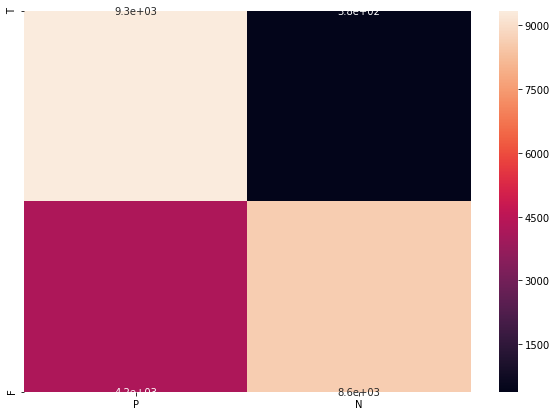

In [7]:
# I added.
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

df_cm = pd.DataFrame(results, index = [i for i in "TF"],
                  columns = [i for i in "PN"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

## Applying SelectFromModel() to find out which features are the most important and should be kept.

In [8]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(clf, prefit=True)

In [9]:
train_x_new = sfm.transform(train_x)
print("Original num features: {}, selected num features: {}"
      .format(train_x.shape[1], train_x_new.shape[1]))

Original num features: 119, selected num features: 7


In [10]:
indices = np.argsort(clf.feature_importances_)[::-1]

In [11]:
for idx, i in enumerate(indices):
    print("{}.\t{} - {}".format(idx, train_x.columns[i], clf.feature_importances_[i]))

0.	src_bytes - 0.739353803124338
1.	service_ecr_i - 0.07537443951799272
2.	service_http - 0.056288533270470384
3.	dst_host_same_srv_rate - 0.030188078488584003
4.	dst_bytes - 0.02235518870418086
5.	hot - 0.02161534757423723
6.	logged_in - 0.010299399024875614
7.	service_ftp_data - 0.007153156775607418
8.	dst_host_srv_count - 0.004581226762306193
9.	protocol_type_tcp - 0.004392896490987884
10.	duration - 0.0036640994569887724
11.	dst_host_srv_diff_host_rate - 0.0033976880323085775
12.	dst_host_rerror_rate - 0.0033742156274434855
13.	count - 0.002156246362157632
14.	dst_host_diff_srv_rate - 0.0018632747975075037
15.	service_private - 0.0015150555545468847
16.	dst_host_srv_serror_rate - 0.0012895009893495672
17.	flag_RSTO - 0.0012092707068345266
18.	dst_host_count - 0.0012087755633389148
19.	service_smtp - 0.0010333469492228471
20.	flag_S1 - 0.0010025689546886581
21.	flag_REJ - 0.0009382141529412343
22.	service_finger - 0.000782544179058021
23.	service_other - 0.0007470303397855699
24.	se